## Bechdel Data Analysis

The Bechdel Test, or Bechdel-Wallace Test, sometimes called the Mo Movie Measure or Bechdel Rule is a simple test 
 which names the following three criteria: \
 1. it has to have at least two women in it, who \
 2. who talk to each other, about \
 3. something besides a man.

The test serves as a lens to evaluate whether a film provides meaningful interaction between female characters, reflecting broader trends in the portrayal of women in the film industry.

In this analysis, we will explore how Bechdel Test results have evolved over the years and across different regions of the world. We will also investigate how these scores relate to other aspects of films, such as revenue, ratings, and the presence of female lead actors.

By examining these relationships, our goal is to understand whether the representation of women in cinema has improved over time and whether films that perform well on the Bechdel Test are correlated with greater success. We aim to validate the theory that female representation is becoming more significant in the industry, potentially influencing a film's reception and success.

In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry_convert as pc
import json
import math
from statsmodels.stats import diagnostic
from scipy import stats
from numpy.polynomial.polynomial import Polynomial

### Getting the Bechdel test database and the Movie database

The code below is used to get the Bechdel test results from the API and store them in a DataFrame

In [2]:
url = 'http://bechdeltest.com/api/v1/getAllMovies'

response = requests.get(url)

if response.status_code == 200:
    print('Request was succesful')
    movie_data = response.json()
    df_bechdel = pd.DataFrame(movie_data)
    print(df_bechdel.sample())

else:
    print('Request failed')

Request was succesful
         title    id  year   imdbid  rating
8916  Wheelman  7869  2017  5723286       1


In [3]:
#We now want to get a quick glimpse of the dataset

print(f'The Bechdel database has {df_bechdel.shape[0]} films')
df_bechdel.sample(10)

The Bechdel database has 10408 films


,title,id,year,imdbid,rating
3377,Lone Star,5295,1996,0116905,2
3820,Bicentennial Man,7620,1999,0182789,3
7793,Boyhood,5508,2014,1065073,3
945,Kronos,8736,1957,0050610,0
2042,Diva,8180,1981,0082269,1
3184,K&ocirc;kaku kid&ocirc;tai (Ghost in the Shell),659,1995,0113568,0
821,Gojira,5505,1954,0047034,1
8716,Prevenge,7886,2016,5154288,3
9579,Come to Daddy,9309,2019,8816194,1
6956,Gone,3071,2012,1838544,3


We are now going to extract the CMU Movie Database, to get additional information from those films 

In [5]:
data_folder = '../projet/Data/MovieSummaries/'

column_names= ['wikipedia_movie_id', 'freebase_id','title','release_date','revenue','runtime','language','countries','genre']

df_movies=pd.read_csv(data_folder + 'movie.metadata.tsv', sep = '\t', names=column_names)

print(f'The CMU Movies database has {df_movies.shape[0]} films')
df_movies.sample(5)


The CMU Movies database has 81741 films


,wikipedia_movie_id,freebase_id,title,release_date,revenue,runtime,language,countries,genre
46262,5812638,/m/0f6l58,Midnight Run for Your Life,1994-06-11,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/05p553"": ""Comedy..."
42092,7893719,/m/026hyvw,A Year Without Love,2005,NaN,95.0,"{""/m/06nm1"": ""Spanish Language""}","{""/m/0jgd"": ""Argentina""}","{""/m/0hn10"": ""LGBT"", ""/m/0hj3n16"": ""Erotic Dra..."
30222,2083964,/m/06l2g2,Let's Scare Jessica to Death,1971-08-06,NaN,88.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/03npn"": ""Horror""..."
25558,20374404,/m/04zz3zw,Genghis Khan,1998,NaN,110.0,"{""/m/0148c4"": ""Mongolian language"", ""/m/03115z...","{""/m/0d05w3"": ""China""}","{""/m/07s9rl0"": ""Drama"", ""/m/03k9fj"": ""Adventur..."
338,16672517,/m/03mhfqj,Aap Kaa Surroor 2 - Ae Himesh Bhai!,NaN,NaN,NaN,"{""/m/03k50"": ""Hindi Language""}","{""/m/03rk0"": ""India""}",{}


#### Code taken from Elsa's branch

This can be deleted if already working with the cleaned dataset

In [6]:
wrong_values = df_movies[
    (df_movies['runtime'] <= 0) |
    (df_movies['runtime'] > 14400)
]

df_movies.loc[wrong_values.index, 'runtime'] = pd.NA

print(f"There are {wrong_values.shape[0]} movies with invalid runtimes. These have been replaced with NaNs.")

There are 2 movies with invalid runtimes. These have been replaced with NaNs.


#### Again my code

In [7]:
#We are going to create a database where we merge the bechdel and the movie database, so that we can have all of the information of those films 
# in one single dataframe. We will merge it on year and title, to avoid having one title of he Bechdel database to many movies in the movie database.

# Convert release_date to datetime format (if it's not already in datetime)
df_movies['release_date'] = pd.to_datetime(df_movies['release_date'], errors='coerce')

# Extract the year from the release_date column
df_movies['year'] = df_movies['release_date'].dt.year

# Merge the datasets by 'title' and 'year'
df_movies_bechdel = pd.merge(df_movies, df_bechdel, how='inner', on=['title', 'year'])


df_movies_bechdel = df_movies_bechdel.rename(columns={'rating':'bechdel_score'})
df_movies_bechdel = df_movies_bechdel.drop(columns=['id']) 
df_movies_bechdel = df_movies_bechdel.drop_duplicates(['title','wikipedia_movie_id'])


print(f'The combined Bechdel and CMU Movies database has {df_movies_bechdel.shape[0]} films')

df_movies_bechdel.head()

The combined Bechdel and CMU Movies database has 3121 films


,wikipedia_movie_id,freebase_id,title,release_date,revenue,runtime,language,countries,genre,year,imdbid,bechdel_score
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,0228333,3
1,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",1989.0,0097499,3
2,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",1964.0,0058331,3
3,12053509,/m/02vn81r,Loverboy,1989-04-28,3960327.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""...",1989.0,0097790,3
4,7767613,/m/026ccts,Star!,1968-07-18,4000000.0,176.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/017fp"": ""Biography"", ""/m/04t36"": ""Musical...",1968.0,0063642,3


### Bechdel test results along the years

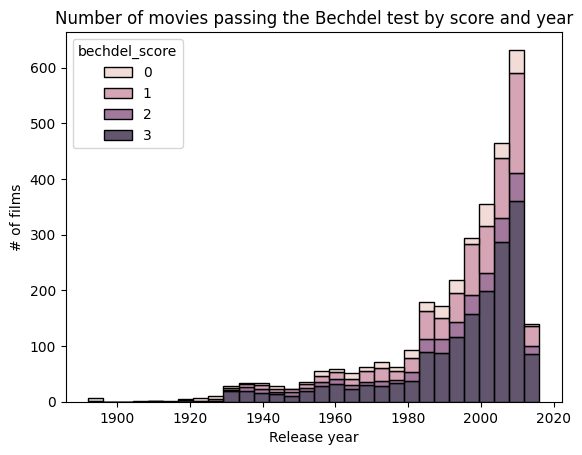

In [8]:
#we here want to plot the number of movies passing the Bechdel test by year and by score

sns.histplot(data=df_movies_bechdel, x='year', hue='bechdel_score',multiple='stack',bins=30)

plt.title('Number of movies passing the Bechdel test by score and year')
plt.xlabel('Release year')
plt.ylabel('# of films');




We observe a clear increase in the number of films passing the Bechdel Test over the years. 

Let's now plot the evolution of the number of films for different scores plotted separately

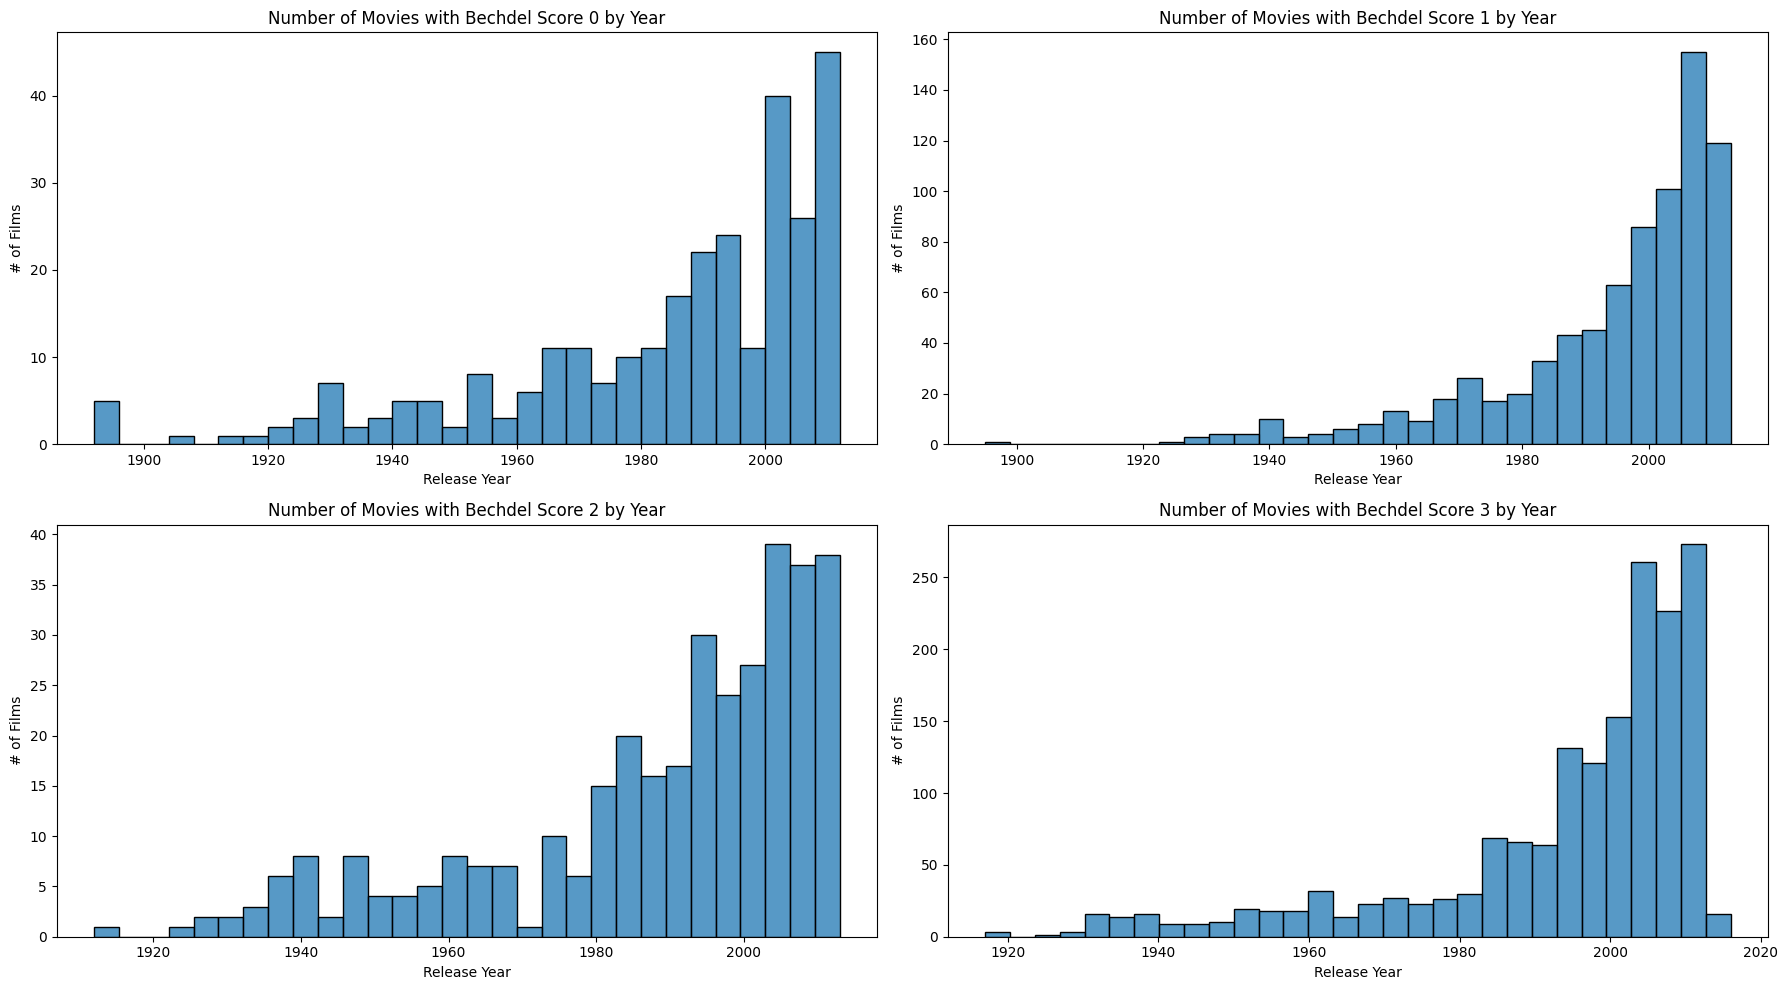

In [9]:
# Set up the figure with 4 subplots (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Define the scores and axes
scores = [0, 1, 2, 3]
titles = [
    "Number of Movies with Bechdel Score 0 by Year",
    "Number of Movies with Bechdel Score 1 by Year",
    "Number of Movies with Bechdel Score 2 by Year",
    "Number of Movies with Bechdel Score 3 by Year"
]

# Loop through each score and corresponding axis
for i, (score, ax) in enumerate(zip(scores, axes.flatten())):
    sns.histplot(
        data=df_movies_bechdel.query(f'bechdel_score == {score}'), 
        x='year', 
        bins=30, 
        ax=ax
    )
    ax.set_title(titles[i])
    ax.set_xlabel('Release Year')
    ax.set_ylabel('# of Films')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


#Here, we will color each score with the ones attributed above

By looking at the scale of the graphs, we can suppose that indeed we now have many more films passing the Bechdel test than failing it.

However, it's still uncertain whether the proportion of films meeting these criteria has genuinely improved over time. To investigate this further, we will analyze the correlation between release years and the average Bechdel Test scores. Additionally, we will visualize the trend by plotting the average scores by year, supplemented with a linear regression line to highlight any patterns.

Pearson Correlation Coefficient: 0.4883, p-value: 1.92402706028908e-07, intercept=-17.97


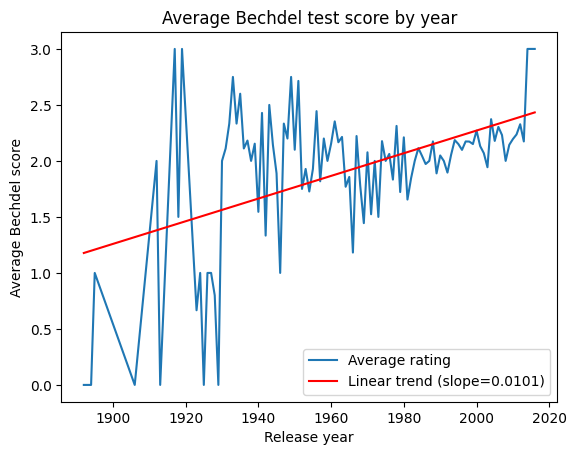

In [16]:
df_year_mbechdel = df_movies_bechdel.groupby('year')['bechdel_score'].agg('mean').reset_index() # Here, we reset index to get the year as a column
df_year_mbechdel = df_year_mbechdel.rename(columns={'bechdel_score':'avg_bechdel_score'})

slope, intercept, rvalue, pvalue, stderr = stats.linregress(df_year_mbechdel['year'],df_year_mbechdel['avg_bechdel_score'])

sns.lineplot(data=df_year_mbechdel, x='year', y='avg_bechdel_score', label='Average rating')
plt.plot(df_year_mbechdel['year'], slope*df_year_mbechdel['year']+intercept, color='red',label=f'Linear trend (slope={slope:.4f})')

plt.legend()

plt.title('Average Bechdel test score by year')
plt.xlabel('Release year')
plt.ylabel('Average Bechdel score');

print(f"Pearson Correlation Coefficient: {rvalue:.4f}, p-value: {pvalue}, intercept={intercept:.2f}")


Pearson Correlation Coefficient: 0.4883, p-value: 1.92402706028908e-07, intercept=-17.97


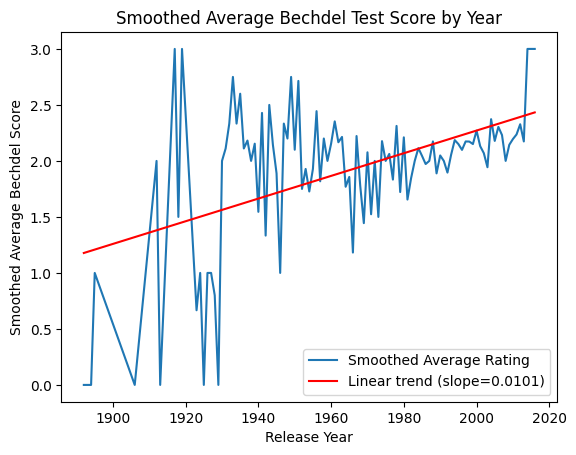

In [13]:
# Group by year, calculate the sum of scores and the count of movies
df_year_stats = df_movies_bechdel.groupby('year').agg(
    total_score=('bechdel_score', 'sum'),
    count=('bechdel_score', 'size')
).reset_index()

# Calculate the weighted average
df_year_stats['weighted_avg_score'] = df_year_stats['total_score'] / df_year_stats['count']

# Rename columns for clarity
df_year_stats = df_year_stats.rename(columns={'weighted_avg_score': 'avg_bechdel_score'})

# Perform linear regression on the smoothed average score
slope, intercept, rvalue, pvalue, stderr = stats.linregress(df_year_stats['year'], df_year_stats['avg_bechdel_score'].fillna(0))

# Plot the smoothed average score
sns.lineplot(data=df_year_stats, x='year', y='avg_bechdel_score', label='Smoothed Average Rating')
plt.plot(df_year_stats['year'], slope * df_year_stats['year'] + intercept, color='red', label=f'Linear trend (slope={slope:.4f})')

plt.legend()
plt.title('Smoothed Average Bechdel Test Score by Year')
plt.xlabel('Release Year')
plt.ylabel('Smoothed Average Bechdel Score')

print(f"Pearson Correlation Coefficient: {rvalue:.4f}, p-value: {pvalue}, intercept={intercept:.2f}")


By these results, we can observe that the Bechdel test results definitely go up as the years go by. This can be interpreted from our positive slope and our negative intercept in the linear regression. Nevertheless our rvalue (or Pearson Correlation Coefficent) tells us that less than half of this increment is due to time passing by, and we should identify other impactful factors.

Lastly, we can affirm that this relationship is most probably not due to randomness, since our p-value is remarkably small.

#### However

We discovered that doing this with the original Bechdel database yielded a quite different result for the pearson correlation coefficient:

Pearson Correlation Coefficient: 0.8064, p-value: 5.662079183511133e-34, intercept=-30.05


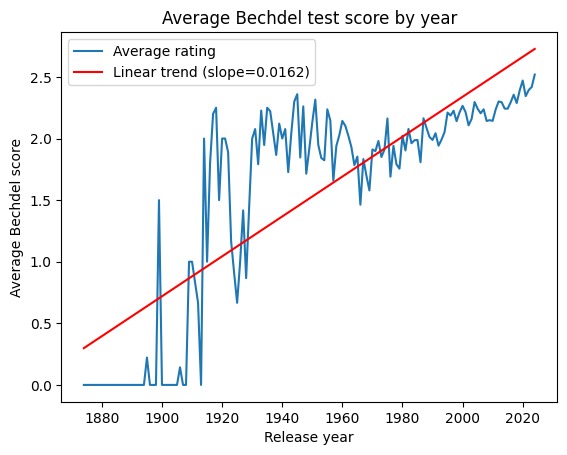

In [17]:
df_year_bechdel = df_bechdel.groupby('year')['rating'].agg('mean').reset_index() # Here, we reset index to get the year as a column
df_year_bechdel = df_year_bechdel.rename(columns={'rating':'avg_bechdel_score'})

slope, intercept, rvalue, pvalue, stderr = stats.linregress(df_year_bechdel['year'],df_year_bechdel['avg_bechdel_score'])

sns.lineplot(data=df_year_bechdel, x='year', y='avg_bechdel_score', label='Average rating')
plt.plot(df_year_bechdel['year'], slope*df_year_bechdel['year']+intercept, color='red',label=f'Linear trend (slope={slope:.4f})')

plt.legend()

plt.title('Average Bechdel test score by year')
plt.xlabel('Release year')
plt.ylabel('Average Bechdel score');

print(f"Pearson Correlation Coefficient: {rvalue:.4f}, p-value: {pvalue}, intercept={intercept:.2f}")


Pearson Correlation Coefficient: 0.4260, p-value: 0.0035268052661507213, intercept=-9.98


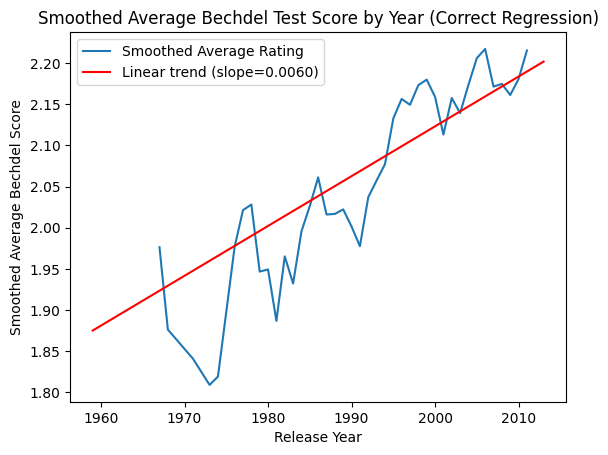

In [18]:
# Group by year and calculate total score and count of movies
df_year_stats = df_movies_bechdel.groupby('year').agg(
    total_score=('bechdel_score', 'sum'),
    count=('bechdel_score', 'size')
).reset_index()

# Filter out years with fewer than 10 movies
df_year_stats = df_year_stats[df_year_stats['count'] >= 15]

# Calculate the weighted average Bechdel score
df_year_stats['avg_bechdel_score'] = df_year_stats['total_score'] / df_year_stats['count']

# Apply smoothing (optional)
df_year_stats['smoothed_avg_score'] = df_year_stats['avg_bechdel_score'].rolling(window=5, center=True).mean()

# Perform linear regression on the original weighted average data, not the smoothed data
slope, intercept, rvalue, pvalue, stderr = stats.linregress(df_year_stats['year'], df_year_stats['avg_bechdel_score'])

# Plot the smoothed average score
sns.lineplot(data=df_year_stats, x='year', y='smoothed_avg_score', label='Smoothed Average Rating')

# Plot the regression line using the original data
plt.plot(df_year_stats['year'], slope * df_year_stats['year'] + intercept, color='red', label=f'Linear trend (slope={slope:.4f})')

plt.legend()
plt.title('Smoothed Average Bechdel Test Score by Year (Correct Regression)')
plt.xlabel('Release Year')
plt.ylabel('Smoothed Average Bechdel Score')


print(f"Pearson Correlation Coefficient: {rvalue:.4f}, p-value: {pvalue}, intercept={intercept:.2f}")


For the original Bechdel Test database, we observe a slope that is 60% steeper, with an even lower intercept and an r-value of around 0.8. This indicates that the Bechdel Test results have a stronger correlation with the release year than previously determined. It is surprising that reducing the dataset to only films present in both databases results in such a different correlation.

By comparing both graphs, it appears that the merged database has fewer films from the late 1800s and early 1900s. However, this observation can be easily confirmed:

All unselected films: Pearson Correlation Coefficient: 0.8019, p-value: 2.3815640449128354e-33, intercept=-31.17
Unselected films after 1920: Pearson Correlation Coefficient: 0.5738, p-value: 1.9231823716772625e-10, intercept=-10.78
Unselected films before 2020: Pearson Correlation Coefficient: 0.7962, p-value: 1.7974102832853303e-31, intercept=-32.04


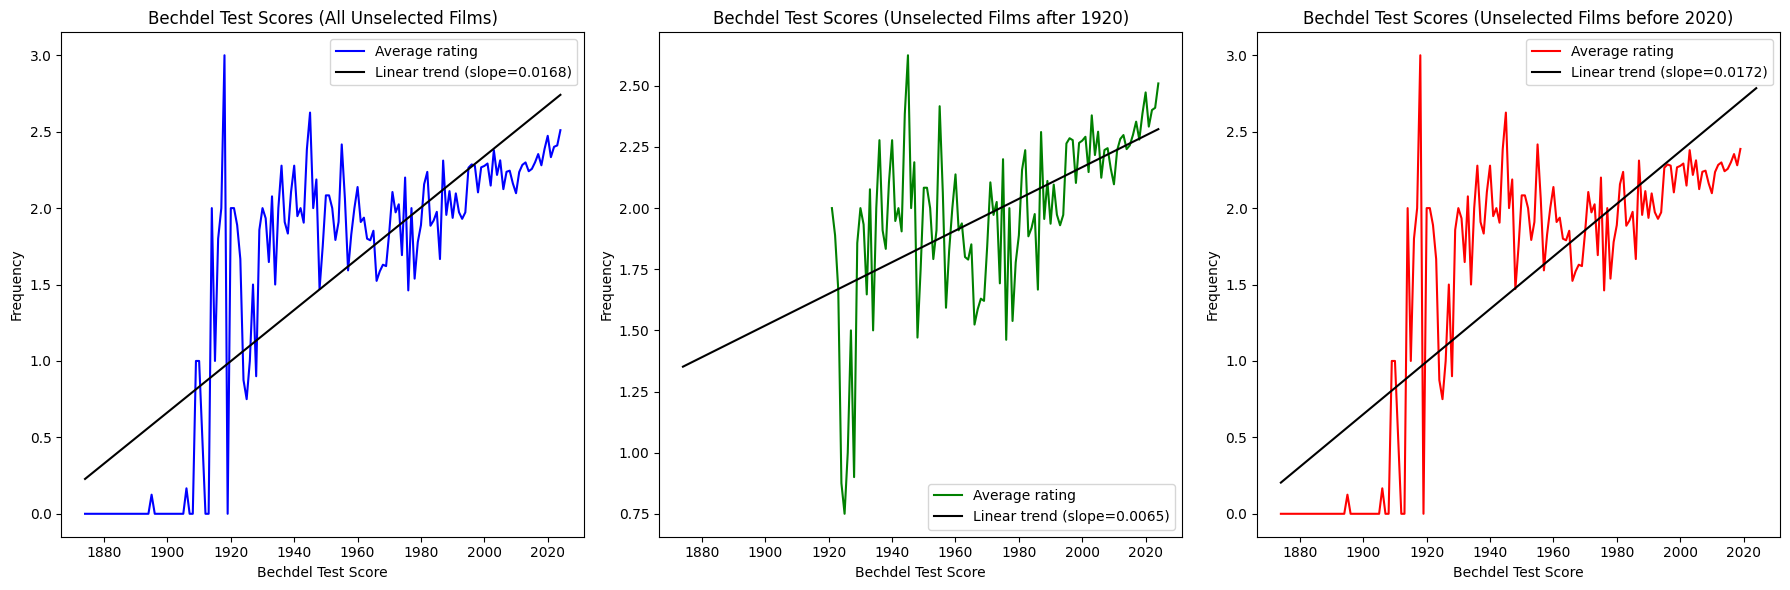

In [18]:
df_bechdel_notmerged=df_bechdel[~df_bechdel['title'].isin(df_movies_bechdel['title'])]

df_year_bechdel_n = df_bechdel_notmerged.groupby('year')['rating'].agg('mean').reset_index() # Here, we reset index to get the year as a column
df_year_bechdel_n = df_year_bechdel_n.rename(columns={'rating':'avg_bechdel_score'})

# Set up the figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: All unselected films (Bechdel scores)
slope, intercept, rvalue, pvalue, stderr = stats.linregress(df_year_bechdel_n['year'],df_year_bechdel_n['avg_bechdel_score'])

sns.lineplot(data=df_year_bechdel_n, x='year', y='avg_bechdel_score', label='Average rating', ax=axes[0], color='blue')
axes[0].plot(df_year_bechdel['year'],slope * df_year_bechdel['year'] + intercept,color='black',label=f'Linear trend (slope={slope:.4f})')

axes[0].set_title('Bechdel Test Scores (All Unselected Films)')
axes[0].set_xlabel('Bechdel Test Score')
axes[0].set_ylabel('Frequency')
axes[0].legend()

print(f"All unselected films: Pearson Correlation Coefficient: {rvalue:.4f}, p-value: {pvalue}, intercept={intercept:.2f}")

# Plot 2: Unselected films excluding those before 1920
slope, intercept, rvalue, pvalue, stderr = stats.linregress(df_year_bechdel_n.query('1920<year')['year'],df_year_bechdel_n.query('1920<year')['avg_bechdel_score'])

sns.lineplot(data=df_year_bechdel_n.query('1920<year'), x='year', y='avg_bechdel_score', label='Average rating', ax=axes[1], color='green')
axes[1].plot(df_year_bechdel['year'],slope * df_year_bechdel['year'] + intercept,color='black',label=f'Linear trend (slope={slope:.4f})')

axes[1].set_title('Bechdel Test Scores (Unselected Films after 1920)')
axes[1].set_xlabel('Bechdel Test Score')
axes[1].set_ylabel('Frequency')
axes[1].legend()

print(f"Unselected films after 1920: Pearson Correlation Coefficient: {rvalue:.4f}, p-value: {pvalue}, intercept={intercept:.2f}")

# Plot 3: Unselected films excluding those after 2020
slope, intercept, rvalue, pvalue, stderr = stats.linregress(df_year_bechdel_n.query('2020>year')['year'],df_year_bechdel_n.query('2020>year')['avg_bechdel_score'])

sns.lineplot(data=df_year_bechdel_n.query('2020>year'), x='year', y='avg_bechdel_score', label='Average rating', ax=axes[2], color='red')
axes[2].plot(df_year_bechdel['year'],slope * df_year_bechdel['year'] + intercept,color='black',label=f'Linear trend (slope={slope:.4f})')

axes[2].set_title('Bechdel Test Scores (Unselected Films before 2020)')
axes[2].set_xlabel('Bechdel Test Score')
axes[2].set_ylabel('Frequency')
axes[2].legend()

print(f"Unselected films before 2020: Pearson Correlation Coefficient: {rvalue:.4f}, p-value: {pvalue}, intercept={intercept:.2f}")

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


We observe that films released before 1920 have a lower average Bechdel test score and significantly influence the correlation between the year of release and the average Bechdel test score.

This is particularly interesting because it suggests that when compiling the Bechdel test database, considerable attention was paid to early cinema, including films from the industry's origins. This focus on early films could explain the stronger correlation observed in the earlier years. Which is not observable in our merged dataset

Based on this analysis, we can draft these two theories:

1. The Bechdel test results have improved over time, indicating a gradual shift towards more meaningful female representation in films.\
        Women were largely absent from lead roles in the early years of cinema, as reflected by the lower Bechdel test scores for films released before 1920.\
2. These conclusions highlight both the historical progression of women's roles in film and the evolving impact of the Bechdel test as a measure\
    of female representation in cinema.

### Bechdel Test Results in Different World Regions

To analyze how the Bechdel test results have evolved across various world regions, we opted to categorize the films by continent. This approach was chosen to avoid the complexities of geopolitical definitions. By utilizing the pycountry_convert library, we can efficiently convert countries into their respective continents.

For simplicity and based on the assumption that the first country listed in the data is the primary producer or responsible entity for the film, we decided to use only the first country in the list to determine the continent.

In [19]:
df_movies_bechdel['countries'].value_counts()

def get_continent(country_list):
    try:
        country_dict=json.loads(country_list)

        if not country_dict:
            return None

        country_name = list(country_dict.values())[0] #I might need to have different continents! Here I only have the first one!
        country_alpha2=pc.country_name_to_country_alpha2(country_name)
        return pc.country_alpha2_to_continent_code(country_alpha2)
    except KeyError or IndexError:
        return None

df_movies_bechdel['continent']=df_movies_bechdel['countries'].apply(get_continent)

df_movies_bechdel['continent'].value_counts()

continent
NA    2521
EU     403
AS     124
OC      21
SA       4
Name: count, dtype: int64

There is a noticeable underrepresentation of non-North American and non-European films in the Bechdel test database. This disparity can be attributed to the test's popularity being primarily concentrated in North America, with limited focus on international films in the analysis.

For clarity and a more focused visualization, we will restrict the plots to films from North America, Europe, and Asia.

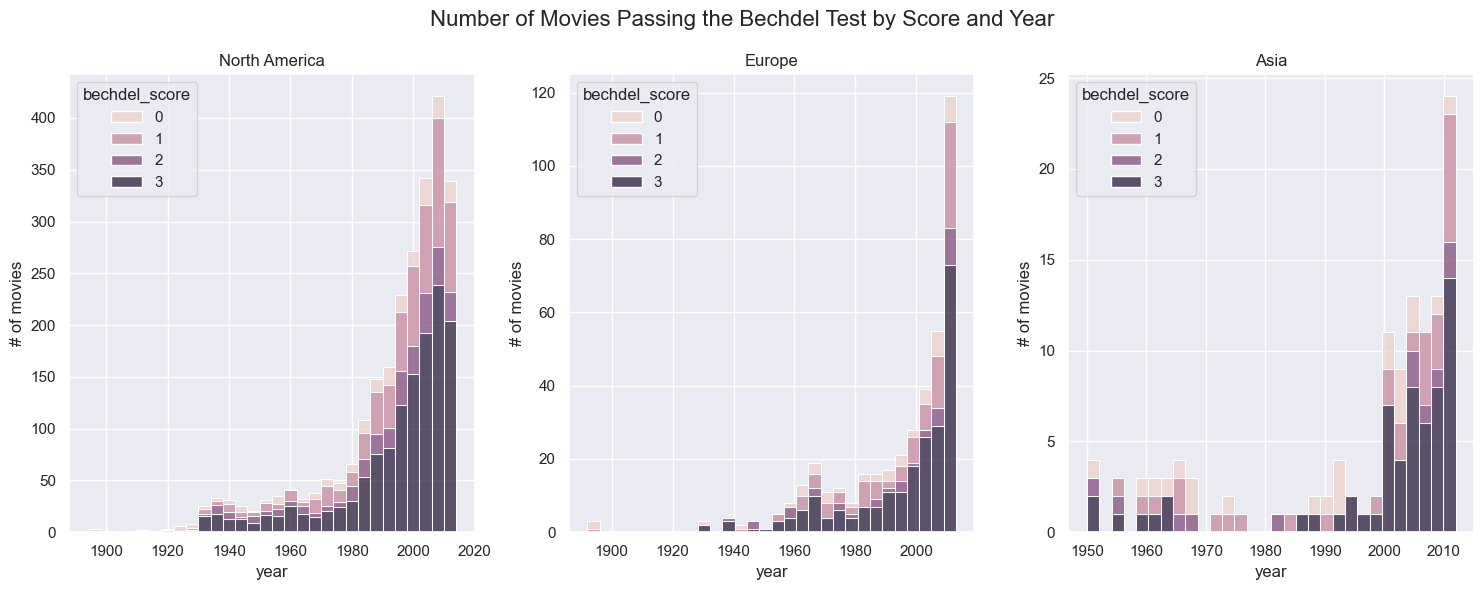

In [30]:
#by region now

sns.set()

fig, axes = plt.subplots(1,3, figsize = (15,6))

fig.suptitle('Number of Movies Passing the Bechdel Test by Score and Year', fontsize=16)

sns.histplot(data=df_movies_bechdel[df_movies_bechdel['continent'] == 'NA'], x='year', hue='bechdel_score', multiple='stack', bins=30, ax=axes[0]).set(title='North America', 
                                                                                                                          ylabel = '# of movies')
sns.histplot(data=df_movies_bechdel[df_movies_bechdel['continent'] == 'EU'], x='year', hue='bechdel_score', multiple='stack', bins=30, ax=axes[1]).set(title='Europe', 
                                                                                                                          ylabel = '# of movies')
sns.histplot(data=df_movies_bechdel[df_movies_bechdel['continent'] == 'AS'], x='year', hue='bechdel_score', multiple='stack', bins=30, ax=axes[2]).set(title='Asia', 
                                                                                                                          ylabel = '# of movies')

plt.tight_layout();




As observed previously, the number of films passing the Bechdel test has increased, but we cannot draw definitive conclusions about the proportion of films passing or failing the test.

Similar to our earlier analysis, we will now calculate the averages by continent. Our first step will be to identify the continents for which we have a significant correlation between the year of release and the average Bechdel test score. This will be assessed using Pearson regression.

In [21]:
df_avg_continent = df_movies_bechdel.pivot_table(
    index='year', 
    columns='continent', 
    values='bechdel_score', 
    aggfunc='mean'
).reset_index()

df_avg_continent.columns = ['year'] + [f'avg_bechdel_score_{col}' for col in df_avg_continent.columns[1:]]


r_score_NA,p_score_NA=stats.pearsonr(df_avg_continent.loc[df_avg_continent['avg_bechdel_score_NA'].notna(),'year'], 
                                    df_avg_continent.loc[df_avg_continent['avg_bechdel_score_NA'].notna(), 'avg_bechdel_score_NA'])
print(f'Pearson regression NA r-score: {r_score_NA:.4f}, p-score:{p_score_NA}')

r_score_EU,p_score_EU=stats.pearsonr(df_avg_continent.loc[df_avg_continent['avg_bechdel_score_EU'].notna(),'year'], 
                                    df_avg_continent.loc[df_avg_continent['avg_bechdel_score_EU'].notna(), 'avg_bechdel_score_EU'])
print(f'Pearson regression EU r-score: {r_score_EU:.4f}, p-score:{p_score_EU}')

r_score_AS,p_score_AS=stats.pearsonr(df_avg_continent.loc[df_avg_continent['avg_bechdel_score_AS'].notna(),'year'], 
                                    df_avg_continent.loc[df_avg_continent['avg_bechdel_score_AS'].notna(), 'avg_bechdel_score_AS'])
print(f'Pearson regression AS r-score: {r_score_AS:.4f}, p-score:{p_score_AS}')

Pearson regression NA r-score: 0.4273, p-score:1.0314173768176473e-05
Pearson regression EU r-score: 0.1829, p-score:0.12683329392506348
Pearson regression AS r-score: 0.2050, p-score:0.18723658561998563


We are unable to perform a linear regression for Europe nor Asia due to very high p-values. This is likely a result of the small number of films from these regions in the Bechdel test database, which limits the statistical power for such analyses.

For North America: Pearson Correlation Coefficient: 0.4273, p-value: 1.0314173768176731e-05, intercept=-16.42


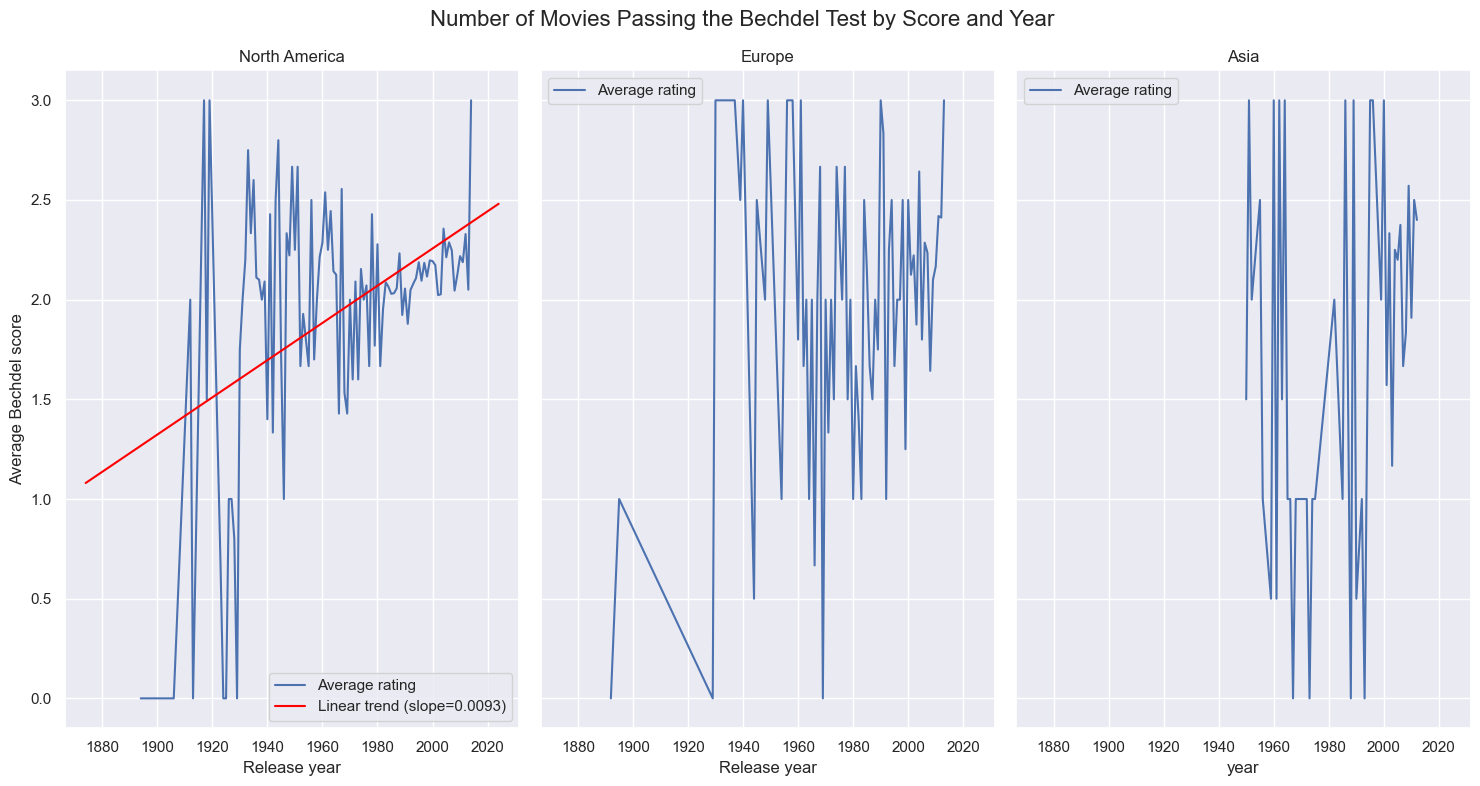

In [22]:
sns.set_theme()

fig, axes = plt.subplots(1,3, figsize = (15,8), sharex=True, sharey = True)

fig.suptitle('Number of Movies Passing the Bechdel Test by Score and Year', fontsize=16)

sns.lineplot(data=df_avg_continent, x='year', y='avg_bechdel_score_NA', label = 'Average rating',ax=axes[0]).set(title='North America',
                                                                                                                  ylabel = 'Averge')
slope_NA, intercept_NA, rvalue_NA, pvalue_NA, stderr = stats.linregress(df_avg_continent.loc[df_avg_continent['avg_bechdel_score_NA'].notna(),'year'], 
                                                            df_avg_continent.loc[df_avg_continent['avg_bechdel_score_NA'].notna(), 'avg_bechdel_score_NA'])
print(f"For North America: Pearson Correlation Coefficient: {rvalue_NA:.4f}, p-value: {pvalue_NA}, intercept={intercept_NA:.2f}")

axes[0].plot(df_year_bechdel['year'],slope_NA * df_year_bechdel['year'] + intercept_NA,color='red',label=f'Linear trend (slope={slope_NA:.4f})')

axes[0].set_xlabel('Release year')
axes[0].set_ylabel('Average Bechdel score')
axes[0].legend()

sns.lineplot(data=df_avg_continent, x='year', y='avg_bechdel_score_EU', label = 'Average rating',ax=axes[1]).set(title='Europe',
                                                                                                                  ylabel = '# of movies')
slope, intercept, rvalue_EU, pvalue, stderr = stats.linregress(df_avg_continent.loc[df_avg_continent['avg_bechdel_score_EU'].notna(),'year'], 
                                                            df_avg_continent.loc[df_avg_continent['avg_bechdel_score_EU'].notna(), 'avg_bechdel_score_EU'])


axes[1].set_xlabel('Release year')
axes[1].set_ylabel('Average Bechdel score')
axes[1].legend()

sns.lineplot(data=df_avg_continent, x='year', y='avg_bechdel_score_AS', label = 'Average rating',ax=axes[2]).set(title='Asia')

plt.tight_layout();





As anticipated, we were unable to obtain meaningful results for European and Asian films due to the limited number of films from these continents in the database. Unfortunately, this means that the Bechdel test results can only be meaningfully analyzed for North American films.

However, as expected, the trend observed for North American films aligns closely with the one found in the merged Bechdel test dataset.

### Female actresses

We will here analyze the impact of the number of female actresses in a movie. Either By genre, or its relatedness to the Bechdel test

In [23]:
#For readability, we are going to set the wikipedia id as index

column_names = ['movie_freebase_id', 'release_date','character_name','birth','gender','character_height', 'actor_ethnicity',
                'actor_name','actor_age', 'actor_gender_freebase_id','character_freebase_id','freebase_character_map']

df_characters=pd.read_csv(data_folder+'/character.metadata.tsv', sep= '\t', names = column_names)

df_characters.index.name='wikipedia_movie_id'

df_characters.sample(5)

,movie_freebase_id,release_date,character_name,birth,gender,character_height,actor_ethnicity,actor_name,actor_age,actor_gender_freebase_id,character_freebase_id,freebase_character_map
wikipedia_movie_id,,,,,,,,,,,,
26958289,/m/0brzs8_,1990,NaN,1919-02-11,F,1.575,/m/0g5y6,Eva Gabor,70.0,/m/0gm1yfy,NaN,/m/013ykx
60293,/m/0gd92,1997-01-23,Banky Edwards,1970-04-25,M,1.870,NaN,Jason Lee,26.0,/m/05ckj7h,/m/03f62k,/m/034np8
31203433,/m/07wvrkc,1989,Nikolai's Wife,NaN,NaN,NaN,NaN,Galina Kasperovich,NaN,/m/0g4yr6l,/m/0g4yr57,/m/0g4yr54
22792066,/m/04j2sbw,2000,NaN,NaN,M,NaN,NaN,Jean-Pierre Lorit,NaN,/m/0gcghzb,NaN,/m/0dbcms
23766166,/m/05pdclg,2010,NaN,1970-02-14,M,1.780,NaN,Simon Pegg,39.0,/m/06zzbdg,NaN,/m/012x2b


#### Connection between the number of lead female actresses and the Bechdel test score

In [24]:
female_counts = df_characters[df_characters['gender'] == 'F'].groupby('wikipedia_movie_id').size().reset_index(name='nbr_female_actresses')

# Merge the counts into df_movies_bechdel, ensuring all rows from df_movies_bechdel are retained (left join)
df_movies_bechdel_characters = df_movies_bechdel.merge(female_counts, on='wikipedia_movie_id', how='left')


df_movies_bechdel_characters.sample(5)

,wikipedia_movie_id,freebase_id,title,release_date,revenue,runtime,language,countries,genre,year,bechdel_score,imdbid,continent,nbr_female_actresses
1012,24676396,/m/07tp08,Late Marriage,2001-05-17,NaN,100.0,"{""/m/05vt3v"": ""Judeo-Georgian Language"", ""/m/0...","{""/m/0f8l9c"": ""France"", ""/m/03spz"": ""Israel""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/03p5xs"": ""...",2001.0,2,0287471,EU,1.0
850,500622,/m/02hvyj,Mystic Pizza,1988-10-21,12793213.0,105.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ...",1988.0,3,0095690,NA,4.0
2364,4306224,/m/0bw6fj,Devil in a Blue Dress,1995-08-03,16140822.0,101.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F...",1995.0,1,0112857,NA,4.0
602,1584981,/m/05ddtv,Under Capricorn,1949-09-08,NaN,117.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvlr"": ""Period piece"", ""/m/07s9rl0"": ""D...",1949.0,3,0042004,EU,2.0
2520,24043964,/m/04mmzxz,Mid-August Lunch,2008-09-05,NaN,75.0,"{""/m/02bjrlw"": ""Italian Language""}","{""/m/03rjj"": ""Italy""}","{""/m/0hj3n0w"": ""Ensemble Film"", ""/m/0clz1b"": ""...",2008.0,3,1277728,EU,2.0


We will start by doing a scatterplot between the Bechdel test score of a film, and the number of female actors in the film.

Pearson correlation: 0.35728094104498753, p-value: 6.669666618540747e-91


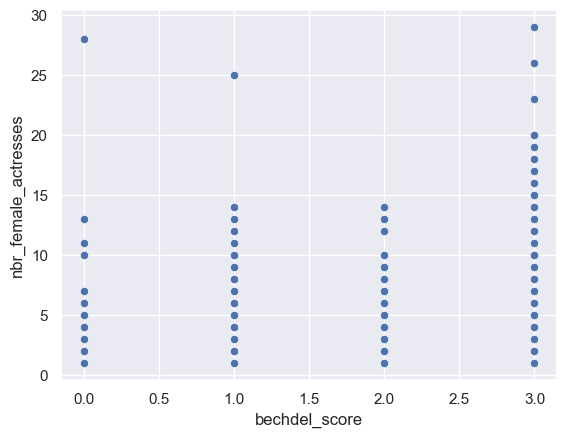

In [25]:
sns.scatterplot(data=df_movies_bechdel_characters, y='nbr_female_actresses',x='bechdel_score')

valid_data = df_movies_bechdel_characters[df_movies_bechdel_characters['nbr_female_actresses'].notna()]

correlation, p_value = stats.pearsonr(valid_data['nbr_female_actresses'], valid_data['bechdel_score'])

print(f"Pearson correlation: {correlation}, p-value: {p_value}")

Nevertheless, we need to remind ourselves that this is probably not an independent variable, and we need to also study the nimber of female actresses along the years.

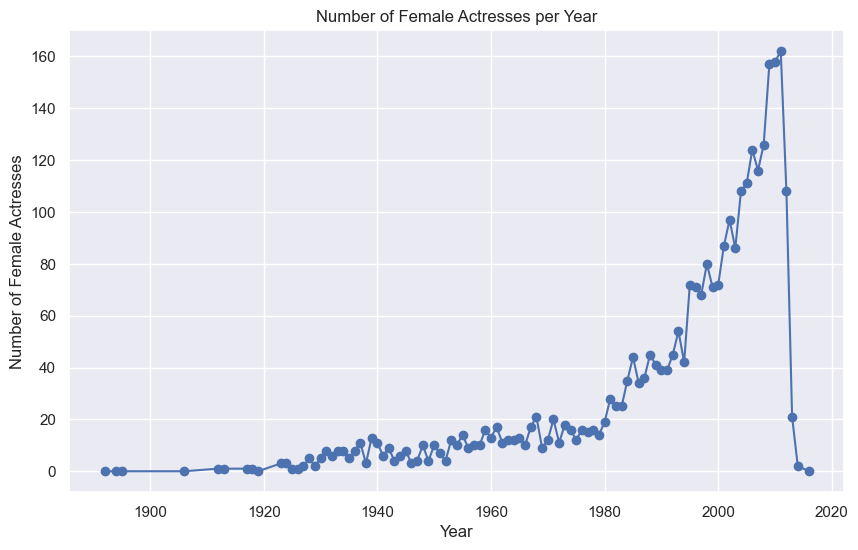

Pearson correlation: 0.7193585617108028, p-value: 1.6441309918845186e-17


In [26]:


df_year_female_actresses = df_movies_bechdel_characters.groupby('year')['nbr_female_actresses'].agg('count').reset_index()

# Step 3: Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df_year_female_actresses['year'], df_year_female_actresses['nbr_female_actresses'], marker='o', linestyle='-', color='b')
plt.title('Number of Female Actresses per Year')
plt.xlabel('Year')
plt.ylabel('Number of Female Actresses')
plt.grid(True)
plt.show()

correlation,p_value =stats.pearsonr(df_year_female_actresses['year'],df_year_female_actresses['nbr_female_actresses'])

print(f"Pearson correlation: {correlation}, p-value: {p_value}")


This correlation is way stronger than the one seen between the number of female actresses and the Bechdel test results. It might be interesting to study the propensity score between the three following variables:
1. Bechdel Test result
2. Number of female actresses
3. Year

The following code is to output the number of female actresses that participate per main genre. (je ne sais pas trop quoi faire avec ça lol, c'est moche et je vois pas où je peux/veux en venir)

primary_genre
Thriller                703
Romantic comedy         297
Crime Fiction           237
Drama                   208
Science Fiction         135
                       ... 
Kitchen sink realism      1
Live action               1
Film adaptation           1
Pornographic movie        1
Concert film              1
Name: count, Length: 144, dtype: int64

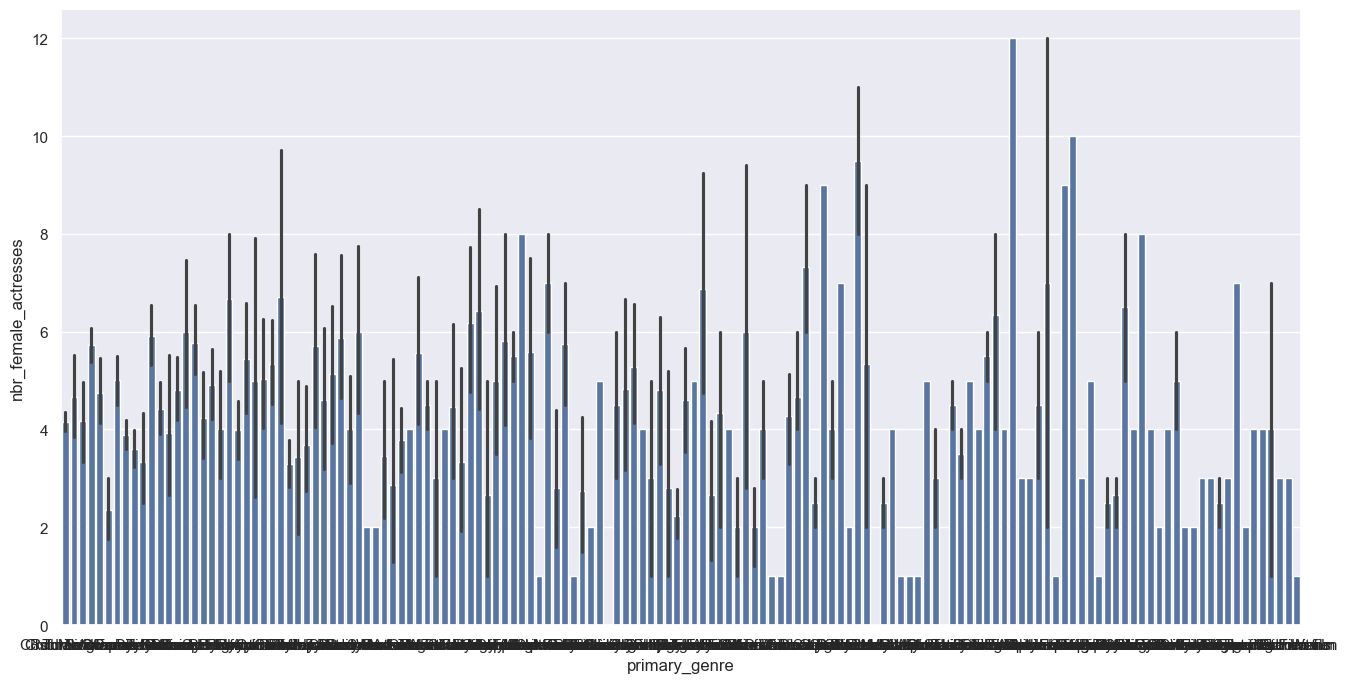

In [27]:
#We will no

def get_primary_genre(genre_list):
    try:
        genre_dict=json.loads(genre_list)

        if not genre_dict:
            return None

        primary_genre = list(genre_dict.values())[0]
        return primary_genre
    except KeyError or IndexError:
        return None


df_movies_bechdel_characters['primary_genre'] = df_movies_bechdel_characters['genre'].apply(get_primary_genre)

plt.figure(figsize=(16, 8))
sns.barplot(data=df_movies_bechdel_characters, y='nbr_female_actresses',x='primary_genre')

df_movies_bechdel_characters['primary_genre'].value_counts()


### Continuation:

First of all, analyse Bechdel test and imdb/revenue (do we have normalized revenue?), and see the impact of more complete interactions between women and the success of a film.

##### Next step: 

After the lectures on "Handling Text Data", we could look for strategies to analyze which lexical fields present in the film summaries are more recurrent in films with higher Bechdel test scores.